## Importing Libraries

In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# for reproducability
np.random.seed(seed = 42)

## Preparing the Data

In [3]:
# read data
movies = pd.read_csv("data/movies.csv") # we'll use this dataframe also later to retrieve title and genres
ratings = pd.read_csv("data/ratings.csv")

print("Columns of movies dataset: ",movies.columns)
print("Columns of ratings dataset: ",ratings.columns)

print("\nNumber of movies in dataset: ", len(movies.movieId.unique()))
print("Number of users in dataset: ", len(ratings.userId.unique()))

# we merge two dataframe to have all the movies including the ones which are not voted
df = pd.merge(ratings, movies, on = "movieId", how="right")

# to obtain the desired matrix form we use pandas.pivot_table function
# users are on the rows, movies are on the columns

C = df.pivot_table(index = "userId", columns = "movieId", values = "rating", dropna=False)

# just to have correct datatype (it is changed because of NA values)
C.index = C.index.astype(int)

C

Columns of movies dataset:  Index(['movieId', 'title', 'genres'], dtype='object')
Columns of ratings dataset:  Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

Number of movies in dataset:  9742
Number of users in dataset:  610


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# each user has at least 20, at max 2698 ratings among the 9742 movies
print("The least voted user has voted {} times".format(C.notnull().sum(axis=1).min()))
print("The most voted user has voted {} times".format(C.notnull().sum(axis=1).max()))

# some movies never rated, at most they rated 329 times by different users
print("The least rated movie has voted {} times".format(C.notnull().sum(axis=0).min()))
print("The most rated movie has voted {} times".format(C.notnull().sum(axis=0).max()))

# minimum and maximum rating
print("Minimum rating:",C.min(axis=0).min())
print("Maximum rating:",C.max(axis=0).max())

The least voted user has voted 20 times
The most voted user has voted 2698 times
The least rated movie has voted 0 times
The most rated movie has voted 329 times
Minimum rating: 0.5
Maximum rating: 5.0


In [5]:
# all unobserved values will be filled with 0 for the sake of cost function
C.fillna(0,inplace=True)
C

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Weighted Alternating Least Squares

In [6]:
num_user, num_item = C.shape
num_factor = 50 # I decided number of features, this number will be decided by using CV later

$$
\sum_{i,j \in Obs}{w_{i,j}(C_{i,j} - U_{i,j} V_{i,j}^T)^2} + \lambda {(\lVert U \rVert^2 + \lVert V \rVert^2)}
$$

In [7]:
def cost_function(C, U, V, reg, w):
    C_prime = np.dot(U, V.T)
    return w * np.sum((C.values - C_prime) ** 2) + reg * (np.linalg.norm(U) ** 2 + np.linalg.norm(V) ** 2)

To optimize the cost function, we start by setting one of the vectors as constant. For this example we can use item vector $V$. Then we can take the derivate of the loss function with respect to other vector. For the sake of simplicity $i,j$ won't be showed in the notation

$$
\frac{\partial L}{\partial U} = -2 \sum{w(C - U V^T) V} + 2 \lambda U = 0 \\
= - w (C - U V^T) V + \lambda U = 0 \\
= U(w V^T V + \lambda I) = w C V \\
= U = w C V (w V^T V + \lambda I)^{-1}
$$

Similarly, we can calculate the $V$ by following same procedure.

$$
\frac{\partial L}{\partial V} = V = w C U (w U^T U + \lambda I)^{-1}
$$

In [8]:
# this is the analytical solution, please note that instead of lambda 
# we used reg as a parameter since lambda exist in python as keyword

def recompute_factors(ratings, fixed_vecs, solve_vecs, num_factor, reg , w):
    
    A = w * fixed_vecs.T.dot(fixed_vecs) + np.eye(num_factor) * reg
    b = w * ratings.dot(fixed_vecs)
    A_inv = np.linalg.inv(A)
    solve_vecs = b.dot(A_inv)
    return solve_vecs

In [9]:
def WALS(C, num_factor, num_user, num_item, reg, num_iter, verbose = False):
    
    cost_list = []                                  # cost_list is for storing cost for each iteration
    # randomly initialize the matrices U and V
    U = np.random.rand(num_user, num_factor)
    V = np.random.rand(num_item, num_factor)
    
    if verbose == True:
        print("Iteration \t\t Cost")
        
    for i in range(1,num_iter+1): # range(1,num_iter +1) to start the iteration from 1 not 0
        
        # fix U and find V , reg and w are chosen by arbitrary (w has no effect on the observations)
        V = recompute_factors(C.T.values, U, V, num_factor, reg , 1)
        # fix V and find U
        U = recompute_factors(C.values, V, U, num_factor, reg, 1)
        
        cost = cost_function(C, U, V, reg, 1)
        
        if verbose == True:
            print(i,"\t\t",cost)
            
        cost_list.append(cost)
    
    # return dataframe which is similar to C
    C_prime = pd.DataFrame(np.dot(U, V.T), columns = C.columns, index = C.index)
        
    return C_prime, cost_list

In [10]:
%%time
C_prime, cost_list = WALS(C, num_factor, num_user, num_item, 0.5, 100, verbose = True)

Iteration 		 Cost
1 		 771879.3781704713
2 		 614338.7316308323
3 		 586468.4934668883
4 		 576450.2703298895
5 		 571701.312833217
6 		 569066.9267586413
7 		 567436.8883683793
8 		 566337.3759754634
9 		 565545.9618455714
10 		 564951.1382773549
11 		 564491.3935186343
12 		 564128.5894458554
13 		 563836.8838719839
14 		 563598.0167299045
15 		 563398.9210518316
16 		 563230.209962241
17 		 563085.104072222
18 		 562958.6596539319
19 		 562847.2227398491
20 		 562748.0496383219
21 		 562659.0454629835
22 		 562578.5840215158
23 		 562505.3829500772
24 		 562438.4161953403
25 		 562376.8518286367
26 		 562320.0071903025
27 		 562267.3160318533
28 		 562218.3040795884
29 		 562172.5705963562
30 		 562129.77427896
31 		 562089.6223348819
32 		 562051.8619226998
33 		 562016.2733726804
34 		 561982.6647644297
35 		 561950.867550739
36 		 561920.7329964332
37 		 561892.1292582806
38 		 561864.9389736688
39 		 561839.0572564271
40 		 561814.3900209931
41 		 561790.8525732544
42 		 561768.

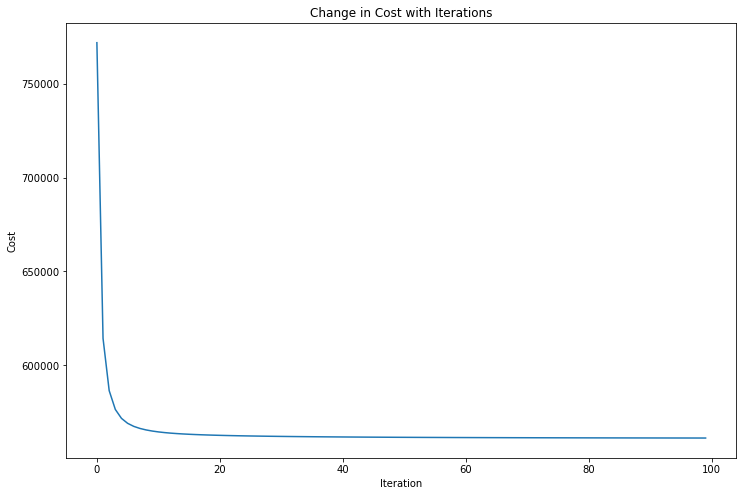

In [11]:
plt.figure(figsize = (12,8))
plt.title("Change in Cost with Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.plot(cost_list);

## Recommendation

In [12]:
def recommend(C, C_prime, user_id, num_recommendation):
    mask = np.where(C == 0)                        # filtering the movies which is not watched
    user = user_id - 1                        # in numpy, indexing starts with 0, in dataframe it is 1

    user_column = mask[1][mask[0] == user]    # to filter movies (were in columns) in C_prime
    
    scores = C_prime.iloc[user,user_column]
    scores_reduced = scores.sort_values(ascending = False)[:num_recommendation]   # sort the scores descending order
    
    df = pd.DataFrame(scores_reduced)
    df.reset_index(inplace=True)                                 # to get movieId as column
    df.columns = ["movieId", "Score"]
    df = pd.merge(df,movies,on="movieId")                        # to get also title and genres
    
    print("Movie Recommendations for user {}".format(user_id))

    return df            

In [13]:
recommend(C, C_prime, 455, num_recommendation=10)

Movie Recommendations for user 455


,movieId,Score,title,genres
0,296,3.556107,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,153,2.313058,Batman Forever (1995),Action|Adventure|Comedy|Crime
2,185,2.164436,"Net, The (1995)",Action|Crime|Thriller
3,47,2.028308,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,208,1.874246,Waterworld (1995),Action|Adventure|Sci-Fi
5,10,1.804685,GoldenEye (1995),Action|Adventure|Thriller
6,474,1.666858,In the Line of Fire (1993),Action|Thriller
7,231,1.665089,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
8,39,1.651651,Clueless (1995),Comedy|Romance
9,21,1.604681,Get Shorty (1995),Comedy|Crime|Thriller


## Deciding Parameters with CV

### Latent Factor

In [14]:
# to use it in cross validation
def calculate_test_error(array1, array2):
    return np.sum(np.square(array1 - array2))

In [15]:
def param_CV(C, param_list, fold, latent_factor = True):
    # mask the observations
    mask = np.nonzero(C.values)
    idx = len(C.values[mask]) // fold  # will be used for indexing mask, in other words test size
    
    param_error = {}                # store the results for each param in dictionary
    for param in param_list:
        print("Evaluating parameter {}".format(param))

        cost = []
        for i in range(fold): 

            C_train = C.copy()              
            test_mask_row = mask[0][i*idx : (i+1)*idx]   # preparing test set
            test_mask_column = mask[1][i*idx : (i+1)*idx]

            # keep those values in a seperated array
            test_array = C_train.values[test_mask_row, test_mask_column]

            # set those values to 0, like we didn't observe them at all
            C_train.iloc[test_mask_row, test_mask_column] = 0.0
            
            # this if statement is just for using the function for latent_factor and reg
            if latent_factor == True:
                # now calculate the C_prime, 30 iteration is enough to converge and save time from execution
                C_prime, cost_list = WALS(C_train, param, C.shape[0], C.shape[1], 0.5, 30)
            else:
                C_prime, cost_list = WALS(C_train, 50, C.shape[0], C.shape[1], param, 30)

            # get the approximated results for test dataset
            predicted_array = C_prime.values[test_mask_row, test_mask_column]

            # calculate the test error and store it
            test_error = calculate_test_error(test_array, predicted_array)
            cost.append(test_error)
              
        param_error[param] = cost
        
    return param_error

In [16]:
%%time
# this part may take time since there is fold * len(param_list) operation

num_latent_list = np.linspace(10,100,10, dtype=np.int)

latent_factor_CV_error = param_CV(C, num_latent_list, 5)
# construct a dataframe from errors
latent_factors_error_df = pd.DataFrame(latent_factor_CV_error, dtype=np.float)

# first take the mean of dataframe columns-wise and sort 
# it according to index to find the minimum among the columns

idx = np.argsort(latent_factors_error_df.mean(axis=0).values)
latent_factors_ordered = latent_factors_error_df.columns[idx]
print("Best number of latent factor is {}".format(latent_factors_ordered[0]))

Evaluating parameter 10
Evaluating parameter 20
Evaluating parameter 30
Evaluating parameter 40
Evaluating parameter 50
Evaluating parameter 60
Evaluating parameter 70
Evaluating parameter 80
Evaluating parameter 90
Evaluating parameter 100
Best number of latent factor is 40
CPU times: user 10min 16s, sys: 33.7 s, total: 10min 50s
Wall time: 4min 20s


### Regularizaiton $\lambda$

In [17]:
%%time

# same process for regularization parameter to get the one which has the smallest error mean

reg_list = np.linspace(0.1,1,10, dtype=np.float)

reg_CV_error = param_CV(C, reg_list, 5 ,latent_factor = False)
reg_error_df = pd.DataFrame(reg_CV_error, dtype=np.float)

idx = np.argsort(reg_error_df.mean(axis=0).values)
reg_ordered = reg_error_df.columns[idx]
print("Best number of regularization parameter is {}".format(reg_ordered[0]))

Evaluating parameter 0.1
Evaluating parameter 0.2
Evaluating parameter 0.30000000000000004
Evaluating parameter 0.4
Evaluating parameter 0.5
Evaluating parameter 0.6
Evaluating parameter 0.7000000000000001
Evaluating parameter 0.8
Evaluating parameter 0.9
Evaluating parameter 1.0
Best number of regularization parameter is 0.30000000000000004
CPU times: user 10min 5s, sys: 33.8 s, total: 10min 38s
Wall time: 4min 17s


## Cold Start Problem

In [18]:
def recommend_with_cold_start(C, C_prime, user_id, num_recommendation):
    # check that user has no rating before, if yes return the most popular movies
    # simply by taking the mean of the movies
    
    user_votes = C.loc[user_id, :].unique()
    
    if len(user_votes) == 1 and user_votes[0] == 0:
        popular_movies = C.mean(axis=0).sort_values()[::-1][:num_recommendation]
        df = pd.DataFrame(popular_movies)
        df.reset_index(inplace=True)                                 # to get movieId as column
        df.columns = ["movieId", "Score"]
        df = pd.merge(df,movies,on="movieId")                        # to get also title and genres
        print("Movie Recommendations for user {}".format(user_id))
        return df
    else:
        # call normal recommend function
        recommend(C, C_prime, user_id, num_recommendation)
    

In [19]:
# add new user to system which has no ratings
C.loc[611,:] = np.zeros(len(C.columns))

# constructing C_prime with new C by using parameters that we found, actually make no difference
# for new users since we recommend them the most popular ones
C_prime, cost_list = WALS(C, 40, C.shape[0], C.shape[1], 0.3, 100)

recommend_with_cold_start(C, C_prime, 611,10)

Movie Recommendations for user 611


,movieId,Score,title,genres
0,318,2.297872,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,2.242226,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,2.108838,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,2571,1.907529,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,593,1.900164,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
5,260,1.738134,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,110,1.563830,Braveheart (1995),Action|Drama|War
7,2959,1.524550,Fight Club (1999),Action|Crime|Drama|Thriller
8,527,1.521277,Schindler's List (1993),Drama|War
9,480,1.460720,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


## References

http://files.grouplens.org/datasets/movielens/ml-latest.zip

https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

https://developers.google.com/machine-learning/recommendation/collaborative/matrix

http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/